<a href="https://colab.research.google.com/github/trancethehuman/ai-workshop-code/blob/main/Onboard_customers_quickly_firecrawl_llm_extract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup Firecrawl as our web scraper

I chose Firecrawl because they ship new features every single week. It's hard not to get excited. It's one of those tools that are built for the era of LLMs so it's ergonomic for that use case alone.

### Create an account on Firecrawl

It's a SaaS service. But [you can also self-host](https://github.com/mendableai/firecrawl/blob/main/SELF_HOST.md) (like Supabase). But for demonstrations purposes, we're signing up for the full capitalistic experience.

[Go here](https://www.firecrawl.dev/) and create a new account.

### Get your Firecrawl API key

Make sure to get your API key from the dashboard. They made it dummy-proof (I was expecting to be annoyed here like the OpenAI dashboard, but no)

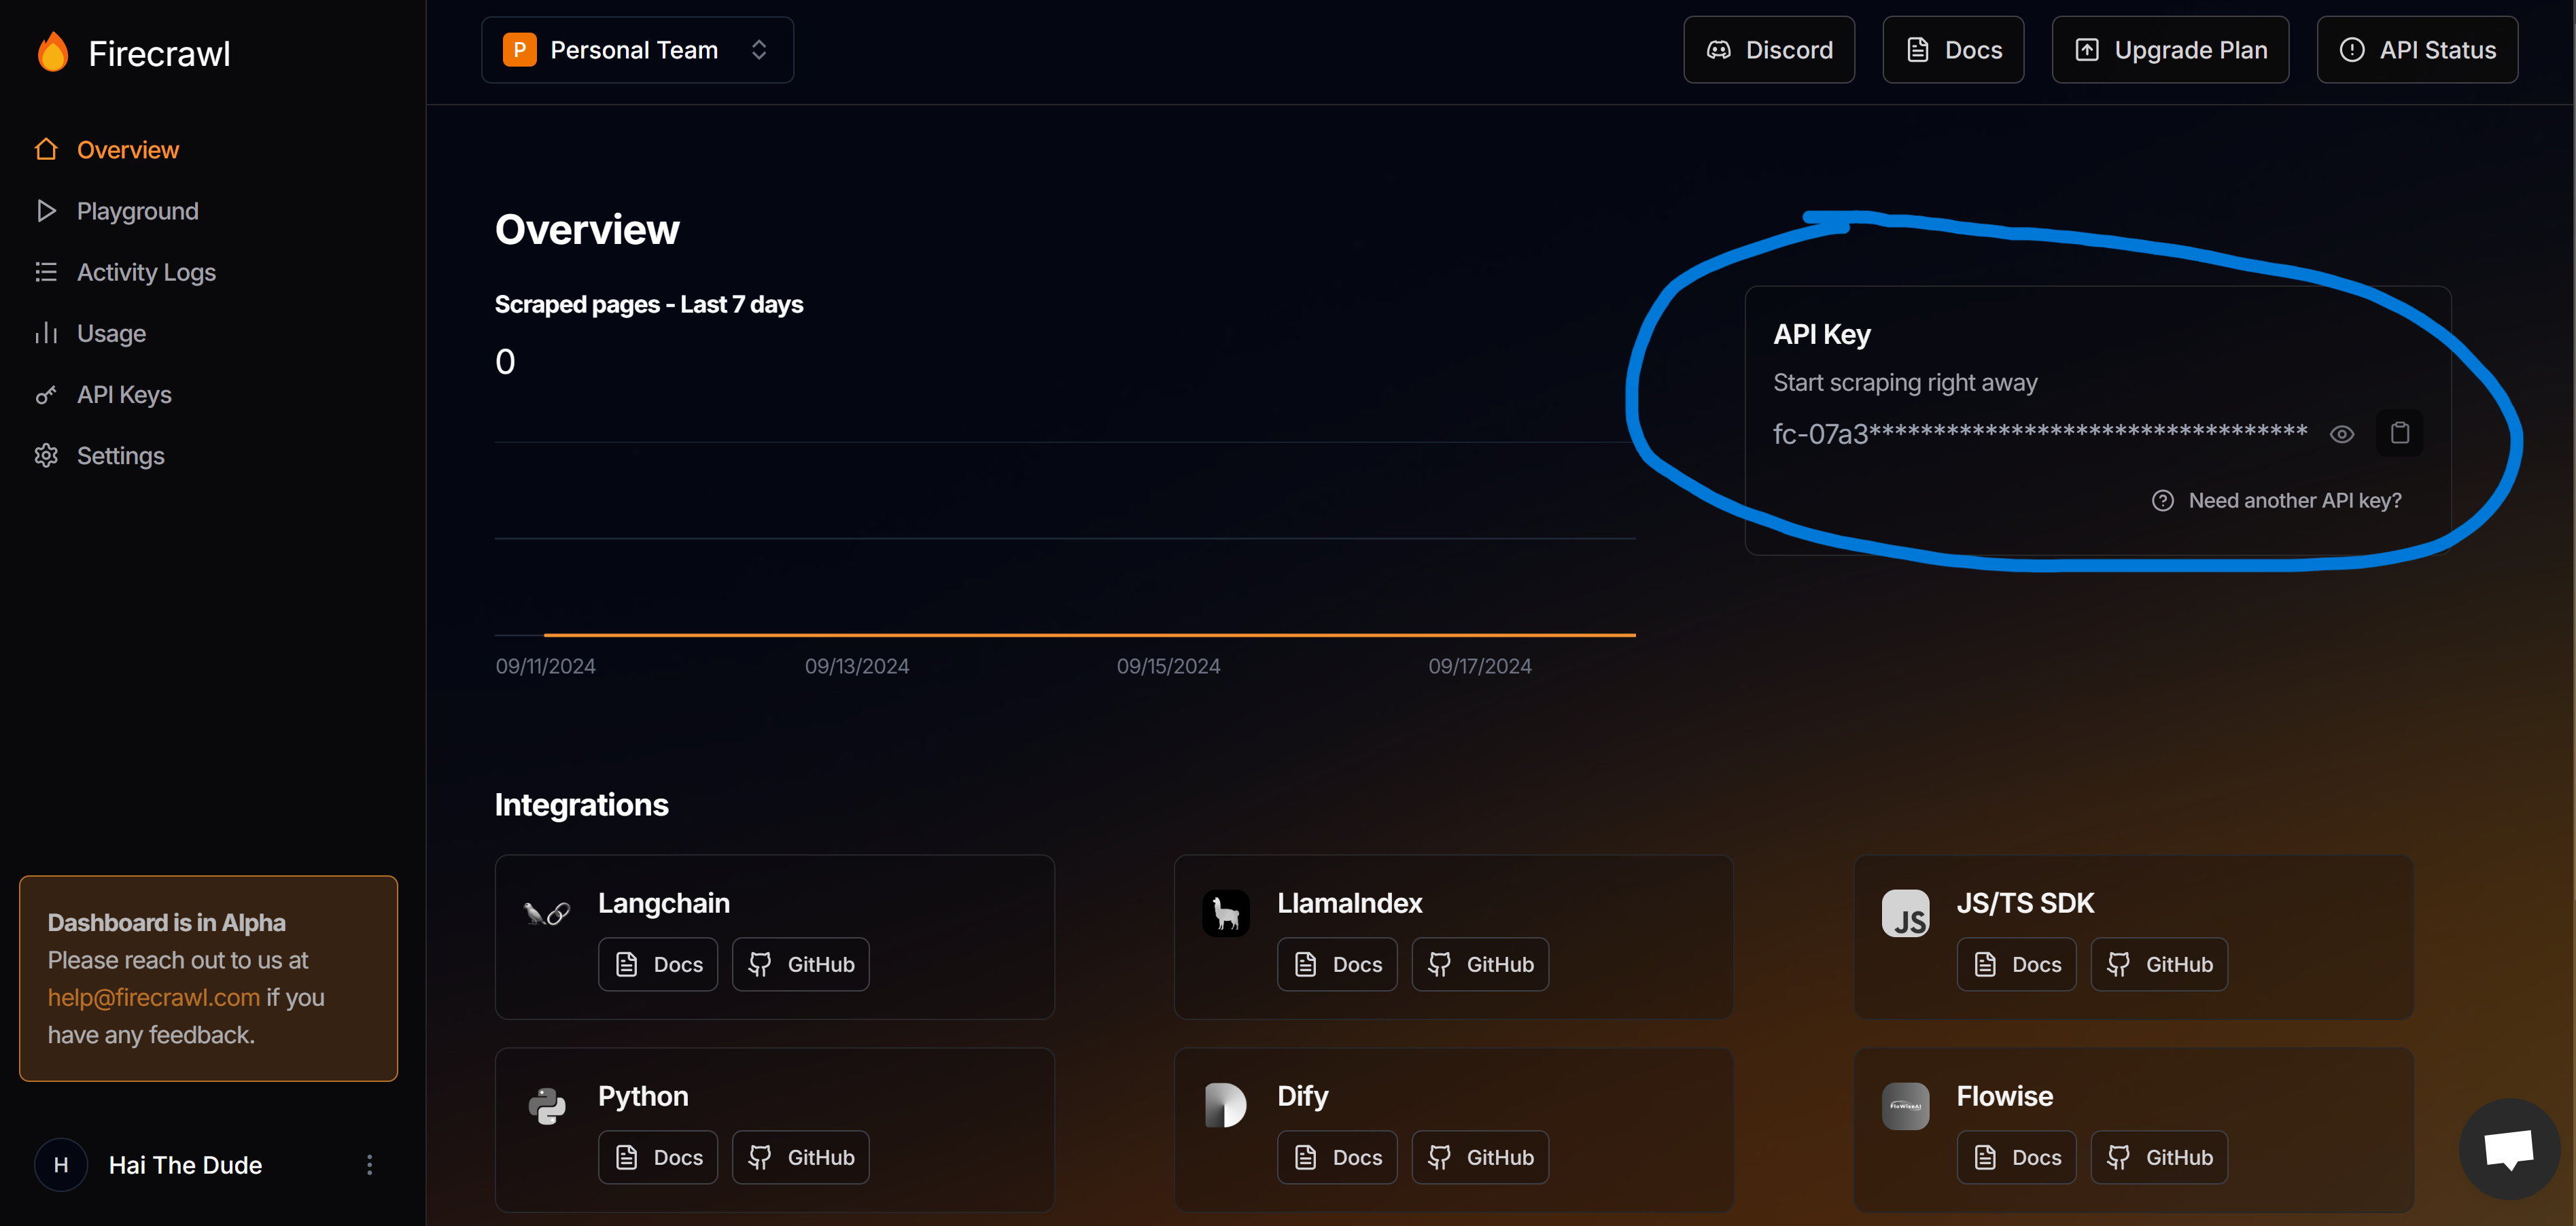

After you're done, we're going to install one (1) package. That's right.

[Their documentation is here](https://docs.firecrawl.dev/introduction), but you can just follow along with me.

### Install dependencies for Firecrawl

Here we're installing the firecrawl Python SDK in `-q` or quiet mode, which helps not cluttering our console.

In [ ]:
pip install firecrawl-py -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 4.3 MB/s eta 0:00:00


And we put our API key in a nice constant. Because this example uses Google Colab, we're using getpass to easily insert our API key at runtime. In a production environment, you don't do this obviously.

In [ ]:
import getpass

FIRECRAWL_API_KEY = getpass.getpass("Mendable API Key: ")

Mendable API Key: ··········


That's it. Now we SCRAPE.

## Let's scrape a website real quick

I lied. Before scraping, I'd like to see my data coming back in a nice format. So we're going to create a quick utility function here called `print_json_and_markdown`. We'll limit to the first 30 lines

In [ ]:
from IPython.display import display, Markdown
import re

def resize_images_in_markdown(markdown_content, max_width=20, hide_images=False):
    """Resize images in markdown content or optionally hide them."""
    def replace_image(match):
        alt_text = match.group(1)
        image_url = match.group(2)
        if hide_images:
            return f'[Image: {alt_text}]'
        return f'<img src="{image_url}" alt="{alt_text}" style="max-width:{max_width}px; height:auto;" title="{alt_text}">'

    # Replace standard markdown image syntax
    markdown_content = re.sub(r'!\[(.*?)\]\((.*?)\)', replace_image, markdown_content)

    # Replace HTML img tags
    if hide_images:
        markdown_content = re.sub(r'<img.*?alt="(.*?)".*?>', lambda m: f'[Image: {m.group(1)}]', markdown_content)
    else:
        markdown_content = re.sub(r'<img.*?src="(.*?)".*?>', lambda m: f'<img src="{m.group(1)}" style="max-width:{max_width}px; height:auto;">', markdown_content)

    return markdown_content

def print_json_and_markdown(data, title, max_width=20, hide_images=False, max_lines=30):
    print(f"\n{title}:")
    # Format and print the JSON data
    json_output = json.dumps(data, indent=2, sort_keys=True)
    json_lines = json_output.split('\n')
    if len(json_lines) > max_lines:
        print('\n'.join(json_lines[:max_lines]))
        print('...')
    else:
        print(json_output)

    # Extract and display markdown content if it exists
    if 'markdown' in data:
        print("\nMarkdown Content:")
        resized_markdown = resize_images_in_markdown(data['markdown'], max_width, hide_images)
        markdown_lines = resized_markdown.split('\n')
        if len(markdown_lines) > max_lines:
            display(Markdown('\n'.join(markdown_lines[:max_lines]) + '\n...'))
        else:
            display(Markdown(resized_markdown))
    elif isinstance(data, list) and 'markdown' in data[0]:
        for i, item in enumerate(data, 1):
            print(f"\nMarkdown Content for item {i}:")
            resized_markdown = resize_images_in_markdown(item['markdown'], max_width, hide_images)
            markdown_lines = resized_markdown.split('\n')
            if len(markdown_lines) > max_lines:
                display(Markdown('\n'.join(markdown_lines[:max_lines]) + '\n...'))
            else:
                display(Markdown(resized_markdown))
    print("\n" + "-"*50 + "\n")  # Separator

Just thinking ahead here: we'd want to capture all the scraped markdown content in a list for later extraction.

In [ ]:
scraped_content = []

Let's try scraping the URL of the shop that I used to go to: https://whitscustard.com/locations/granville

In [ ]:
from firecrawl import FirecrawlApp
import json

app = FirecrawlApp(api_key=FIRECRAWL_API_KEY)

scrape_response = app.scrape_url(
    'https://whitscustard.com/locations/granville',
    params={'formats': ['markdown']}
)

scraped_content.append(scrape_response["markdown"])

print_json_and_markdown(scrape_response, "Scraping website")




Scraping website:
{
  "markdown": " WHIT\u2019S FROZEN CUSTARD OF GRANVILLE \u2014 Whit's Frozen Custard            \n\nNo results found.\n\n[![Whit's Frozen Custard](https://whitscustard.com/images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1585327287115-BSJM9O5GFCU0I45J8GRR/banner_logo_no_slogan.jpg?format=1500w)](/)\n\n[![Whit's Frozen Custard](https://whitscustard.com/images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1585327287115-BSJM9O5GFCU0I45J8GRR/banner_logo_no_slogan.jpg?format=1500w)](/)\n\nOur Stores\n==========\n\n[![Whit's Frozen Custard](https://whitscustard.com/images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1585327287115-BSJM9O5GFCU0I45J8GRR/banner_logo_no_slogan.jpg?format=1500w)](/)\n\n![granville2.jpg](https://images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1653498134373-O87PJT2KXK74UDFU4CQJ/granville2.jpg?format=100w)\n\n![CAF25823-00A3-48AF-A8F7-621874593BA3.jpeg](https://images.squarespace-cdn.com/content/v

 WHIT’S FROZEN CUSTARD OF GRANVILLE — Whit's Frozen Custard            

No results found.

[<img src="https://whitscustard.com/images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1585327287115-BSJM9O5GFCU0I45J8GRR/banner_logo_no_slogan.jpg?format=1500w" style="max-width:20px; height:auto;">](/)

[<img src="https://whitscustard.com/images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1585327287115-BSJM9O5GFCU0I45J8GRR/banner_logo_no_slogan.jpg?format=1500w" style="max-width:20px; height:auto;">](/)

Our Stores
==========

[<img src="https://whitscustard.com/images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1585327287115-BSJM9O5GFCU0I45J8GRR/banner_logo_no_slogan.jpg?format=1500w" style="max-width:20px; height:auto;">](/)

<img src="https://images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1653498134373-O87PJT2KXK74UDFU4CQJ/granville2.jpg?format=100w" style="max-width:20px; height:auto;">

<img src="https://images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1644241299919-BNENTS4FVUU7D4F7QOE4/CAF25823-00A3-48AF-A8F7-621874593BA3.jpeg?format=100w" style="max-width:20px; height:auto;">

<img src="https://images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1603044674002-W0V3K0NKNWUNW1CR2OF5/Granville+3.jpg?format=100w" style="max-width:20px; height:auto;">

<img src="https://images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1653498134373-O87PJT2KXK74UDFU4CQJ/granville2.jpg" style="max-width:20px; height:auto;"><img src="https://images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1644241299919-BNENTS4FVUU7D4F7QOE4/CAF25823-00A3-48AF-A8F7-621874593BA3.jpeg" style="max-width:20px; height:auto;"><img src="https://images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1603044674002-W0V3K0NKNWUNW1CR2OF5/Granville+3.jpg" style="max-width:20px; height:auto;">

Granville is the original home of Whit's Frozen Custard, opening its doors in 2003. Our town's New England character and historic architecture offer a charming setting for our store, right in the middle of the main village street. We love seeing lines out our door and folks gathered around outside on warm days, enjoying our made fresh daily custard and catching up with friends. Granville is home to Denison University and we love seeing students during their study breaks, as well as being a part of all the downtown festivals in Granville.

[226 E Broadway GRANVILLE, OH 43023](http://maps.google.com/maps?q=%0A226%20E%20Broadway%20%20GRANVILLE%2C%20OH%2043023%0A%0A)

###   
[740-587-3620](tel:7405873620)

  [Directions](https://goo.gl/maps/DgXvKRTxy2py7ecg7)
     [Apply](/application/granville)
...


--------------------------------------------------



Let me quickly explain what we did there:

Scrape: Firecrawl went onto our website, https://whitscustard.com/locations/granville, and was able to get the content in markdown format (`params={'formats': ['markdown']}`). This is the beauty of web scraping tools like Firecrawl - this markdown output can easily be read by an LLM to do extraction.



Now let's try and 'crawl' this website. Even though we can eyeball a few details like the shop's address and business phone numbers, we'd still want to get the details of some of the ice cream flavours available for purchase.

To help save time, we can crawl from the main domain and let Firecrawl crawls sub-links to find it all.

In [ ]:
# Crawl a website
crawl_response = app.crawl_url(
    'https://whitscustard.com/',
    params={
        'limit': 2,
        'scrapeOptions': {'formats': ['markdown']}
    }
)

scraped_content.extend(site["markdown"] for site in crawl_response["data"])

print_json_and_markdown(crawl_response['data'], "Crawling website")


Crawling website:
[
  {
    "markdown": " Find Your Whit's \u2014 Whit's Frozen Custard          \n\nNo results found.\n\nNo results found.\n\n[![Whit's Frozen Custard](https://whitscustard.com/images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1585327287115-BSJM9O5GFCU0I45J8GRR/banner_logo_no_slogan.jpg?format=1500w)](/)\n\n![DSC02297.jpg](https://images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1592232443927-CNVHJ5XEGZWYSG807OEE/DSC02297.jpg?format=1500w)\n\n[![Whit's Frozen Custard](https://whitscustard.com/images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1585327287115-BSJM9O5GFCU0I45J8GRR/banner_logo_no_slogan.jpg?format=1500w)](/)\n\nFind Your Whit's\n================\n\n[![Whit's Frozen Custard](https://whitscustard.com/images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1585327287115-BSJM9O5GFCU0I45J8GRR/banner_logo_no_slogan.jpg?format=1500w)](/)\n\nFind the Whit\u2019s Nearest You\n===========================\n\nWhit\u2019s F

 Find Your Whit's — Whit's Frozen Custard          

No results found.

No results found.

[<img src="https://whitscustard.com/images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1585327287115-BSJM9O5GFCU0I45J8GRR/banner_logo_no_slogan.jpg?format=1500w" style="max-width:20px; height:auto;">](/)

<img src="https://images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1592232443927-CNVHJ5XEGZWYSG807OEE/DSC02297.jpg?format=1500w" style="max-width:20px; height:auto;">

[<img src="https://whitscustard.com/images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1585327287115-BSJM9O5GFCU0I45J8GRR/banner_logo_no_slogan.jpg?format=1500w" style="max-width:20px; height:auto;">](/)

Find Your Whit's
================

[<img src="https://whitscustard.com/images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1585327287115-BSJM9O5GFCU0I45J8GRR/banner_logo_no_slogan.jpg?format=1500w" style="max-width:20px; height:auto;">](/)

Find the Whit’s Nearest You
===========================

Whit’s Frozen Custard can be found in 9 states across the US! Click on your state and find the Whit’s closest to you!  
Please check store social media pages for special holiday hours.
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

[<img src="https://images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1596998476064-X34PHX5XL11D1OLSNY0J/states-01.png?format=2500w" style="max-width:20px; height:auto;">](/alabama-locations)

Alabama

[<img src="https://images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1596999307551-P25E5K0R5Y5WQGPVLA5M/states-02.png?format=2500w" style="max-width:20px; height:auto;">](/florida-locations)

...


Markdown Content for item 2:


 Whit's Frozen Custard          

No results found.

[<img src="https://whitscustard.com/images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1585327287115-BSJM9O5GFCU0I45J8GRR/banner_logo_no_slogan.jpg?format=1500w" style="max-width:20px; height:auto;">](/)

<img src="https://images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1586140633461-PYKHGBXKHJZL82MM5WPM/Pints_Dutch_angle.jpeg?format=1500w" style="max-width:20px; height:auto;">

[<img src="https://whitscustard.com/images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1585327287115-BSJM9O5GFCU0I45J8GRR/banner_logo_no_slogan.jpg?format=1500w" style="max-width:20px; height:auto;">](/)

simple. fresh. happy.
=====================

[Find My Whit’s](/findyourwhits)

[<img src="https://whitscustard.com/images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1585327287115-BSJM9O5GFCU0I45J8GRR/banner_logo_no_slogan.jpg?format=1500w" style="max-width:20px; height:auto;">](/)

[<img src="https://images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1664479879017-A11RBA5N1POGZWX9SA86/Whitser+Web.png?format=500w" style="max-width:20px; height:auto;">](/flavors/whitser-of-the-month)

[Whitser of the Month](/flavors/whitser-of-the-month)

[<img src="https://images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1664480443502-WBI4PL603QQEHIXQRRIC/WOm+Web.png?format=500w" style="max-width:20px; height:auto;">](/flavors/whittie-of-the-month)

[Whittie of the Month](/flavors/whittie-of-the-month)

[<img src="https://images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1664482397235-3O3WVYN9GROMXGKC673U/quarts+web.png?format=500w" style="max-width:20px; height:auto;">](/flavors/flavor-of-the-week)

[flavor of the week](/flavors/flavor-of-the-week)

Share The Love
...


--------------------------------------------------



Here, instead of scraping just one website, we crawled.

Crawl: Firecrawl tries to scrape the URL we gave it, then as many URLs that are present in the content of that page as we want. This is defined as below:

```python
params={
        'limit': 2,
        'scrapeOptions': {'formats': ['markdown']}
}
```

Crawling can be very useful when you have an unknown number of sub-links to discover. In our case, it's better for the shop owner to just drop the main domain URL into our application and get onboarded than to keep track of all of his links.

Let's quickly look at the captured markdowns from the sites we scraped and crawled.

In [ ]:
print(scraped_content)

[" WHIT’S FROZEN CUSTARD OF GRANVILLE — Whit's Frozen Custard            \n\nNo results found.\n\n[![Whit's Frozen Custard](https://whitscustard.com/images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1585327287115-BSJM9O5GFCU0I45J8GRR/banner_logo_no_slogan.jpg?format=1500w)](/)\n\n[![Whit's Frozen Custard](https://whitscustard.com/images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1585327287115-BSJM9O5GFCU0I45J8GRR/banner_logo_no_slogan.jpg?format=1500w)](/)\n\nOur Stores\n==========\n\n[![Whit's Frozen Custard](https://whitscustard.com/images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1585327287115-BSJM9O5GFCU0I45J8GRR/banner_logo_no_slogan.jpg?format=1500w)](/)\n\n![granville2.jpg](https://images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1653498134373-O87PJT2KXK74UDFU4CQJ/granville2.jpg?format=100w)\n\n![CAF25823-00A3-48AF-A8F7-621874593BA3.jpeg](https://images.squarespace-cdn.com/content/v1/5e765b4c27758651114287b9/1644241299919-BNE

Looks good. Now we define an extraction pipeline to get only the details we care about. We'll be using `llama-3.1-70b-versatile` from Groq.

## Extract relevant details from scraped content to build our shop's profile in JSON

First, if you don't have an account on Groq, [create one here](https://groq.com/). It's free.

Then, get your API key from Groq (left side panel).

Let's install Groq.

In [ ]:
pip install groq -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.8 MB/s eta 0:00:00


Then, we setup a Groq client with Llama 3.1 70B.

In [ ]:
from groq import Groq
import getpass

GROQ_API_KEY=getpass.getpass("Groq API Key: ")

client = Groq(api_key=GROQ_API_KEY)


Groq API Key: ··········


Before we start extracting, let's create a utility function to take in a list of markdown content, go through each of them, extract and build a dictionary of our shop's details, then combine the dictionaries at the end for a complete overview of the shop.

### Setup the extraction function and declare what to extract (duh)

Let's declare what we want to extract

In [ ]:
def generate_custom_schema() -> str:
    schema = {
        "business_name": "str",
        "business_address": {"street": "str", "city": "str", "zip_code": "str"},
        "menu_items": [{"item_name": "str", "item_description": "str"}],
        "operating_hours": [{"day": "str", "time": "str"}],
        "phone": "str"
    }
    return json.dumps(schema, indent=2)

Let's create the system prompt. It should have enough instructions for the LLM to find the right data to extract and respond in the format we wanted.

In [ ]:
system_message = f"""
You're an expert at doing data extraction on website content into JSON format. The response should include the following properties in the JSON:

{generate_custom_schema()}

Please provide the extracted information in a format that matches this JSON schema.
"""

print(system_message)


You're an expert at doing data extraction on website content into JSON format. The response should include the following properties in the JSON:

{
  "business_name": "str",
  "business_address": {
    "street": "str",
    "city": "str",
    "zip_code": "str"
  },
  "menu_items": [
    {
      "item_name": "str",
      "item_description": "str"
    }
  ],
  "operating_hours": [
    {
      "day": "str",
      "time": "str"
    }
  ],
  "phone": "str"
}

Please provide the extracted information in a format that matches this JSON schema.



In [ ]:
from typing import List, Dict

def extract(website_markdown_content: List[str]) -> Dict[str, Dict]:
    result = {}

    for content in website_markdown_content:
        completion = client.chat.completions.create(
            model="llama-3.1-70b-versatile",
            messages=[
                {
                    "role": "system",
                    "content": system_message
                },
                {
                    "role": "user",
                    "content": content
                }
            ],
            temperature=0,
            max_tokens=8000,
            top_p=1,
            stream=False,
            response_format={"type": "json_object"},
            stop=None,
        )

        # Extract the JSON content from the response
        extracted_info = json.loads(completion.choices[0].message.content)

        # Use the business name as the key in the result dictionary
        business_name = extracted_info.get('business_name', 'Business name not found')
        result[business_name] = extracted_info

    return result

Let's run this through the first scraped site and see what it returns

In [ ]:
from pprint import pprint

pprint(extract([scraped_content[0]]))

{"Whit's Frozen Custard": {'business_address': {'city': 'GRANVILLE',
                                                'street': '226 E Broadway',
                                                'zip_code': 'OH 43023'},
                           'business_name': "Whit's Frozen Custard",
                           'menu_items': [],
                           'operating_hours': [{'day': 'Monday',
                                                'time': '7:30am - 8:30 pm'},
                                               {'day': 'Tuesday',
                                                'time': '7:30am - 8:30 pm'},
                                               {'day': 'Wednesday',
                                                'time': '9:00am - 8:30 pm'},
                                               {'day': 'Thursday',
                                                'time': '7:30am - 8:30pm'},
                                               {'day': 'Friday',
                              

Boom. Now we have what we needed to fill out some of the shop's details. But there's more. Let's it through the rest of the scraped content list.

In [ ]:
extracted_content_by_site = [extract([content]) for content in scraped_content]

pprint(extracted_content_by_site)

[{"Whit's Frozen Custard": {'business_address': {'city': 'GRANVILLE',
                                                 'street': '226 E Broadway',
                                                 'zip_code': 'OH 43023'},
                            'business_name': "Whit's Frozen Custard",
                            'menu_items': [],
                            'operating_hours': [{'day': 'Monday',
                                                 'time': '7:30am - 8:30 pm'},
                                                {'day': 'Tuesday',
                                                 'time': '7:30am - 8:30 pm'},
                                                {'day': 'Wednesday',
                                                 'time': '9:00am - 8:30 pm'},
                                                {'day': 'Thursday',
                                                 'time': '7:30am - 8:30pm'},
                                                {'day': 'Friday',
                

Now we merge all the found data together into one object for easy management

In [ ]:
from collections import defaultdict

def merge_dicts_by_key(dict_list):
    merged = defaultdict(lambda: {
        'business_name': '',
        'business_address': {'street': '', 'city': '', 'zip_code': ''},
        'phone': '',
        'operating_hours': [],
        'menu_items': []
    })

    for d in dict_list:
        for business_name, details in d.items():
            # Merge non-list fields
            if details.get('business_name'):
                merged[business_name]['business_name'] = details['business_name']
            if details.get('phone'):
                merged[business_name]['phone'] = details['phone']

            # Merge address
            for key in ['street', 'city', 'zip_code']:
                if details.get('business_address', {}).get(key):
                    merged[business_name]['business_address'][key] = details['business_address'][key]

            # Merge list fields
            merged[business_name]['operating_hours'].extend(details.get('operating_hours', []))
            merged[business_name]['menu_items'].extend(details.get('menu_items', []))

    # Convert defaultdict back to regular dict
    return dict(merged)

merged_data = merge_dicts_by_key(extracted_content_by_site)

# Print the result
import json
print(json.dumps(merged_data, indent=2))

{
  "Whit's Frozen Custard": {
    "business_name": "Whit's Frozen Custard",
    "business_address": {
      "street": "226 E Broadway",
      "city": "GRANVILLE",
      "zip_code": "OH 43023"
    },
    "phone": "740-587-3620",
    "operating_hours": [
      {
        "day": "Monday",
        "time": "7:30am - 8:30 pm"
      },
      {
        "day": "Tuesday",
        "time": "7:30am - 8:30 pm"
      },
      {
        "day": "Wednesday",
        "time": "9:00am - 8:30 pm"
      },
      {
        "day": "Thursday",
        "time": "7:30am - 8:30pm"
      },
      {
        "day": "Friday",
        "time": "7:30am - 9:00pm"
      },
      {
        "day": "Saturday",
        "time": "8:00am - 9:00pm"
      },
      {
        "day": "Sunday",
        "time": "9:00am - 8:30 pm"
      }
    ],
    "menu_items": [
      {
        "item_name": "German Chocolate Cake",
        "item_description": "German Chocolate Custard with chunks of rich Chocolate Cake, Toasted Coconut Flakes, and swir

Awesome. Now if we have a real application, we can parse this data and set up this shop in no time!